In [1]:
import sys
sys.executable
! pip3 install seaborn
! pip3 install textblob
! pip3 install wordcloud
! pip install scikit-learn



In [12]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [13]:
df = pd.read_csv('vaccination_tweets.csv')

In [14]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8082 non-null   int64 
 1   user_name         8082 non-null   object
 2   user_location     6452 non-null   object
 3   user_description  7576 non-null   object
 4   user_created      8082 non-null   object
 5   user_followers    8082 non-null   int64 
 6   user_friends      8082 non-null   int64 
 7   user_favourites   8082 non-null   int64 
 8   user_verified     8082 non-null   bool  
 9   date              8082 non-null   object
 10  text              8082 non-null   object
 11  hashtags          6133 non-null   object
 12  source            8081 non-null   object
 13  retweets          8082 non-null   int64 
 14  favorites         8082 non-null   int64 
 15  is_retweet        8082 non-null   bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 899.9+ KB


In [16]:
df.isnull().sum()

id                     0
user_name              0
user_location       1630
user_description     506
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            1949
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [17]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [18]:
text_df = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1)
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [20]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 



In [21]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8082 entries, 0 to 8081
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8082 non-null   object
dtypes: object(1)
memory usage: 63.3+ KB


In [22]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [23]:
text_df.text = text_df['text'].apply(data_processing)

In [24]:
text_df = text_df.drop_duplicates('text')

In [25]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [26]:
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))

In [27]:
text_df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...


In [28]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

folks said daikon paste could treat cytokine storm pfizerbiontech 

world wrong side history year hopefully biggest vaccination effort weve ev 

coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine created last 24 years 

facts immutable senator even youre ethically sturdy enough acknowledge 1 born 

explain need vaccine borisjohnson matthancock whereareallthesickpeople pfizerbiontech 



In [29]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7812 entries, 0 to 8081
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7812 non-null   object
dtypes: object(1)
memory usage: 122.1+ KB


In [30]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [31]:
text_df['polarity'] = text_df['text'].apply(polarity)

In [32]:
text_df.head(10)

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.000
1,world wrong side history year hopefully bigges...,-0.500
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000
3,facts immutable senator even youre ethically s...,0.100
4,explain need vaccine borisjohnson matthancock ...,0.000
5,anyone useful adviceguidance whether covid vac...,0.400
6,bit sad claim fame success vaccination patriot...,-0.100
7,many bright days 2020 best 1 bidenharris winni...,0.675
8,covid vaccine getting covidvaccine covid19 pfi...,0.000
9,covidvaccine states start getting covid19vacci...,0.000


In [33]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [35]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [36]:
text_df.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral


<AxesSubplot:xlabel='sentiment', ylabel='count'>

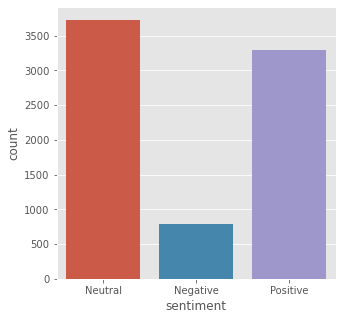

In [37]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

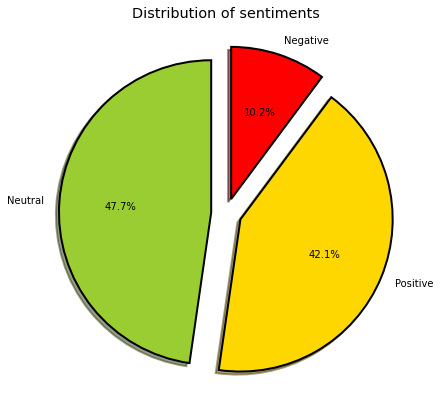

In [38]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [39]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,text,polarity,sentiment
5889,prguy17 scottythequeuejumper resignaustralians...,1.0,Positive
2340,applying emotion pfizerbiontech based best evi...,1.0,Positive
7859,excellent news israel pfizerbiontech pfizervac...,1.0,Positive
6378,cnn sputnikv vaccine seems best even doctors w...,1.0,Positive
5942,vaccines work excellent news thelancet study p...,1.0,Positive


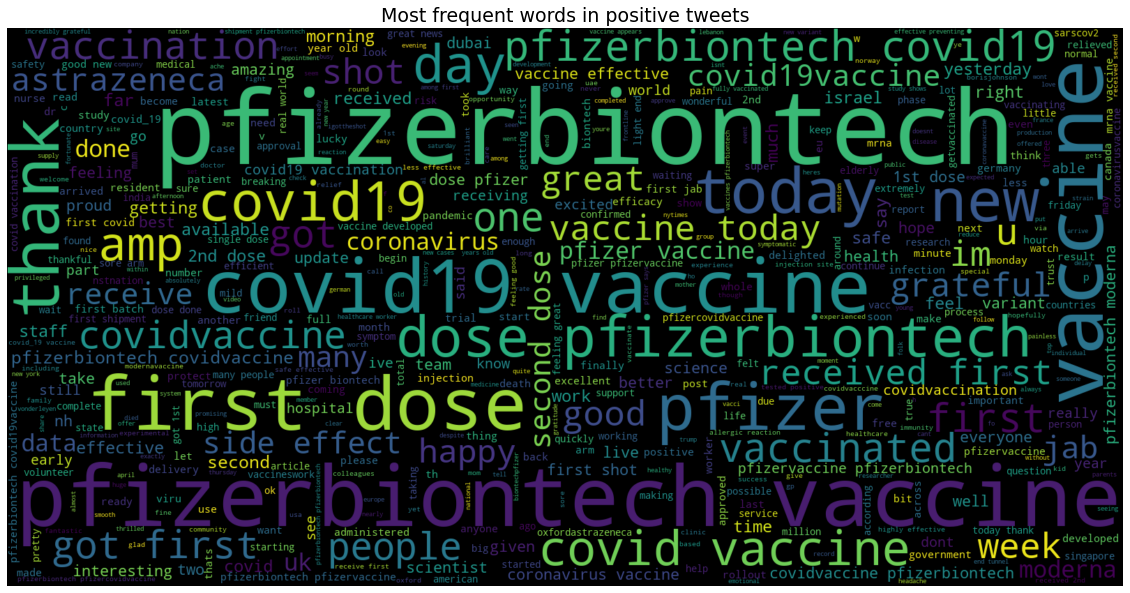

In [40]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [41]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,text,polarity,sentiment
2912,work skilled nursing facility got first vaccin...,-0.003333,Negative
7256,200321 752308 vaccinations new daily record da...,-0.003409,Negative
2073,ukgovernment cant even vaccinate properly ethi...,-0.004762,Negative
7715,got first dose less waiting time airport vacci...,-0.005556,Negative
7157,nas_k27 second dose due end next month well fa...,-0.006250,Negative


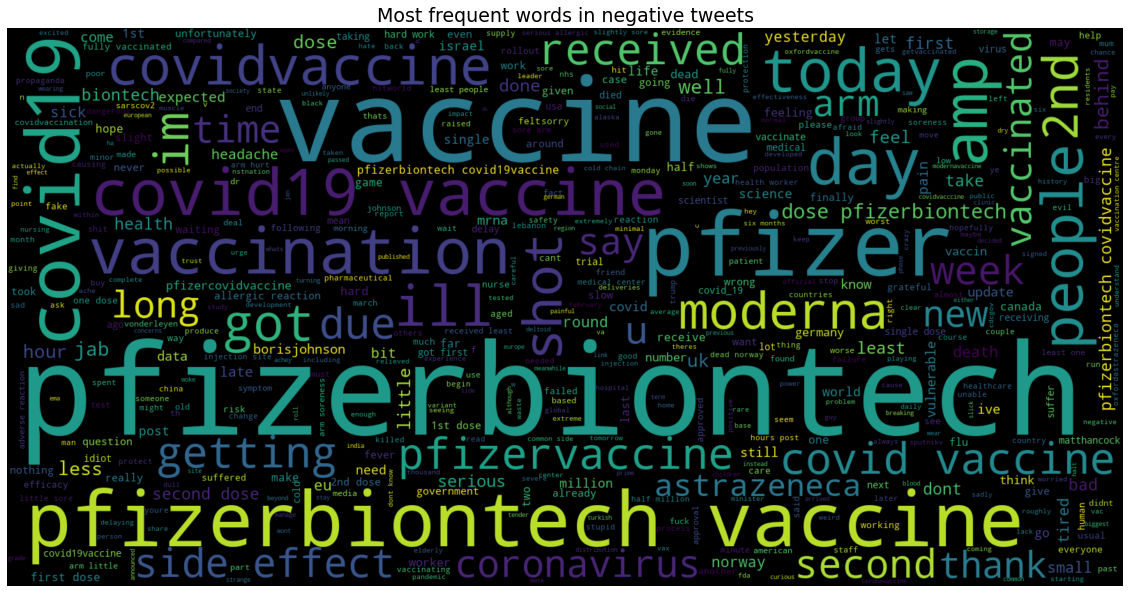

In [53]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [43]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
5405,vaccines revealed covid edition started get si...,0.0,Neutral
5380,got 1st dose pfizerbiontech covid19vaccine see...,0.0,Neutral
5385,vaccinated sg frontliners firstdose pfizerbion...,0.0,Neutral
5386,dramirkhangp literally side effects pfizerbion...,0.0,Neutral


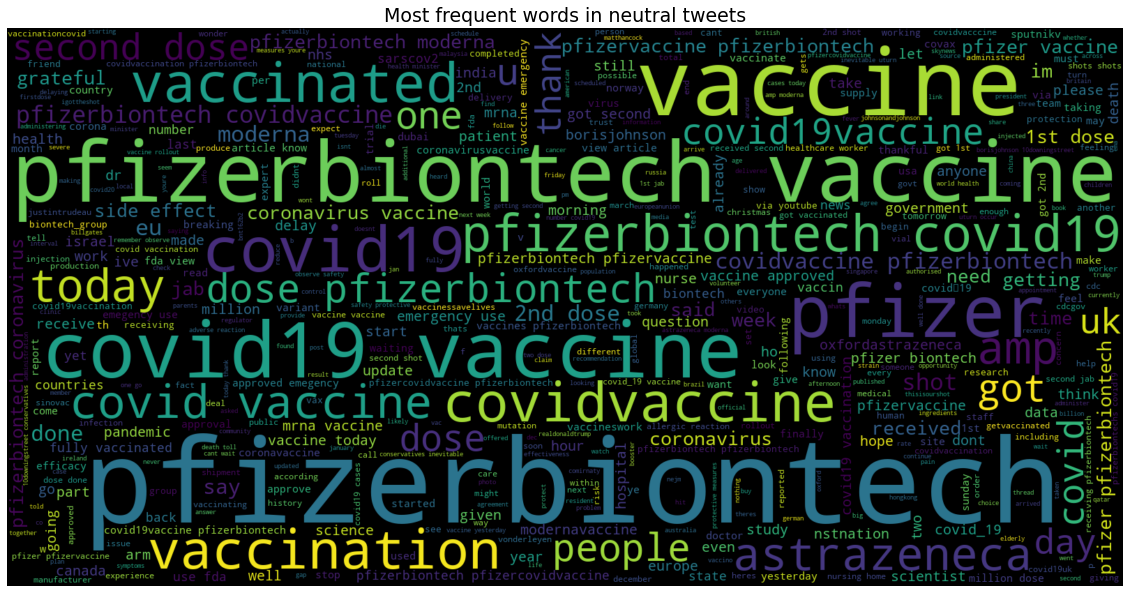

In [44]:
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [45]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [46]:
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 61105

First 20 features:
 ['000', '000 doses', '000 initial', '000 people', '000 vaccines', '0000001', '0000001 covid19', '004', '004 covid', '004 israelis', '02', '02 175', '02 adverse', '02012021', '02012021 grateful', '040120', '045', '045 ml', '045 pe', '05']


In [47]:
X = text_df['text']
Y = text_df['sentiment']
X = vect.transform(X)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [49]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (6249, 61105)
Size of y_train: (6249,)
Size of x_test: (1563, 61105)
Size of y_test: (1563,)


In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 83.30%


In [52]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 43  87  28]
 [  4 694  10]
 [  8 124 565]]


              precision    recall  f1-score   support

    Negative       0.78      0.27      0.40       158
     Neutral       0.77      0.98      0.86       708
    Positive       0.94      0.81      0.87       697

    accuracy                           0.83      1563
   macro avg       0.83      0.69      0.71      1563
weighted avg       0.84      0.83      0.82      1563

